<a href="https://colab.research.google.com/github/rohitrv8922/Face-Emotion-Recognition-Detection/blob/main/Face_Emotion_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#EDA

In [2]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Project Introduction

Import Libraries

In [3]:
# Importing all the required Libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from tensorflow.keras.utils import plot_model
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras.layers import Activation, BatchNormalization, Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.utils import to_categorical

In [4]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        print(os.listdir("../input"))

In [5]:
df='/content/drive/My Drive/'
data = pd.read_csv(df+'/Dataset/icml_face_data.csv')


In [6]:
data.head()

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [7]:
def prepare_data(data):
    """ Prepare data for modeling 
        input: data frame with labels und pixel data
        output: image and label array """
    
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))

    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, ' pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image

    return image_array, image_label

def plot_examples(label=0):
    fig, axs = plt.subplots(1, 5, figsize=(25, 12))
    fig.subplots_adjust(hspace = .2, wspace=.2)
    axs = axs.ravel()
    for i in range(5):
        idx = data[data['emotion']==label].index[i]
        axs[i].imshow(train_images[idx][:,:,0], cmap='gray')
        axs[i].set_title(emotions[train_labels[idx].argmax()])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])    

def plot_all_emotions():
    fig, axs = plt.subplots(1, 7, figsize=(30, 12))
    fig.subplots_adjust(hspace = .2, wspace=.2)
    axs = axs.ravel()
    for i in range(7):
        idx = data[data['emotion']==i].index[i]
        axs[i].imshow(train_images[idx][:,:,0], cmap='gray')
        axs[i].set_title(emotions[train_labels[idx].argmax()])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])

def plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, image_number):
    """ Function to plot the image and compare the prediction results with the label """
     
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
    
    bar_label = emotions.values()
    
    axs[0].imshow(test_image_array[image_number], 'gray')
    axs[0].set_title(emotions[test_image_label[image_number]])
    
    axs[1].bar(bar_label, pred_test_labels[image_number], color='orange', alpha=0.7)
    axs[1].grid()
    
    plt.show()

def plot_compare_distributions(array1, array2, title1='', title2=''):
    df_array1 = pd.DataFrame()
    df_array2 = pd.DataFrame()
    df_array1['emotion'] = array1.argmax(axis=1)
    df_array2['emotion'] = array2.argmax(axis=1)
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
    x = emotions.values()
    
    y = df_array1['emotion'].value_counts()
    keys_missed = list(set(emotions.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[0].bar(x, y.sort_index(), color='orange')
    axs[0].set_title(title1)
    axs[0].grid()

    y = df_array2['emotion'].value_counts()
    keys_missed = list(set(emotions.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[1].bar(x, y.sort_index())
    axs[1].set_title(title2)
    axs[1].grid()
    
    plt.show()            

#5. Callback Functions

In [8]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

def callbackFunction(modelName):
  checkpoint = ModelCheckpoint(f"Checkpoints/{modelName}.h5", monitor = "val_accuracy", save_best_only = True, mode = "auto", verbose = 1)
  early_stopping = EarlyStopping(monitor = "val_accuracy", patience = 10, verbose = 1)
  callbacks = [early_stopping, checkpoint]
  return callbacks

#6. More about the dataset

In [9]:
data[' Usage'].value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name:  Usage, dtype: int64

#7. Creating the label dictionary

In [10]:
emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

#8. Training, Testing and Validation Split

In [11]:
train_image_array, train_image_label = prepare_data(data[data[' Usage']=='Training'])
val_image_array, val_image_label = prepare_data(data[data[' Usage']=='PrivateTest'])
test_image_array, test_image_label = prepare_data(data[data[' Usage']=='PublicTest'])

In [12]:
train_images = train_image_array.reshape((train_image_array.shape[0], 48, 48, 1))
train_images = train_images.astype('float32')/255

val_images = val_image_array.reshape((val_image_array.shape[0], 48, 48, 1))
val_images = val_images.astype('float32')/255

test_images = test_image_array.reshape((test_image_array.shape[0], 48, 48, 1))
test_images = test_images.astype('float32')/255

In [13]:
train_labels = to_categorical(train_image_label)
val_labels = to_categorical(val_image_label)
test_labels = to_categorical(test_image_label)

#9. Examples from the dataset

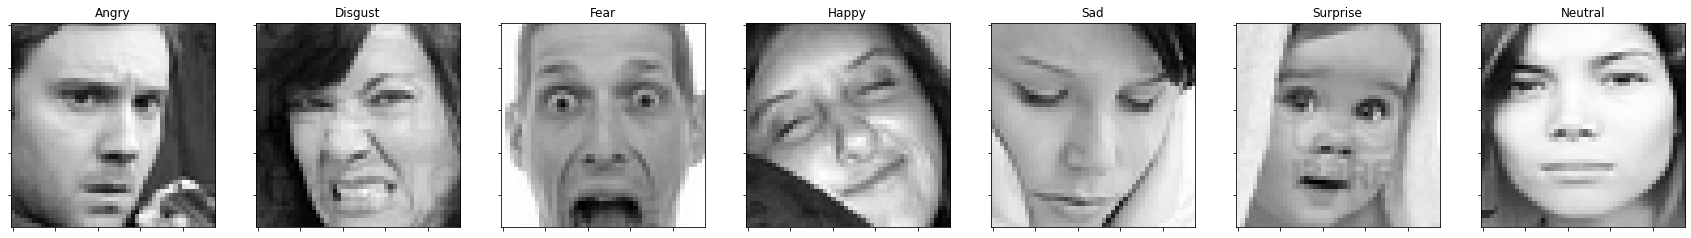

In [14]:
plot_all_emotions()

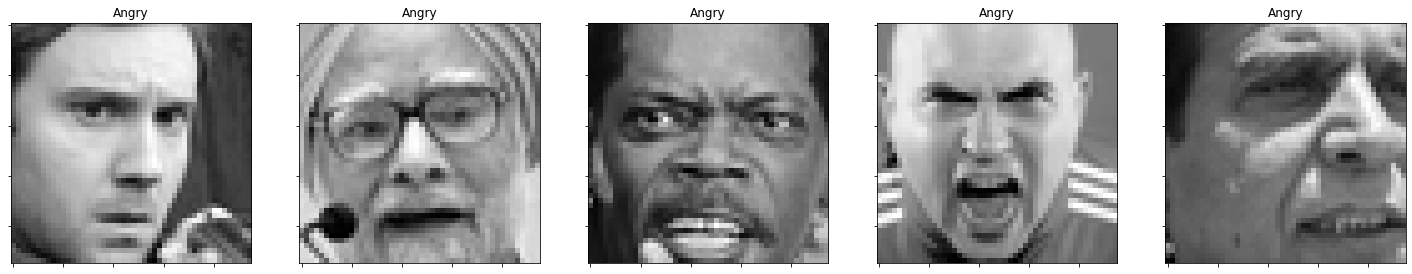

In [15]:
plot_examples(label=0)

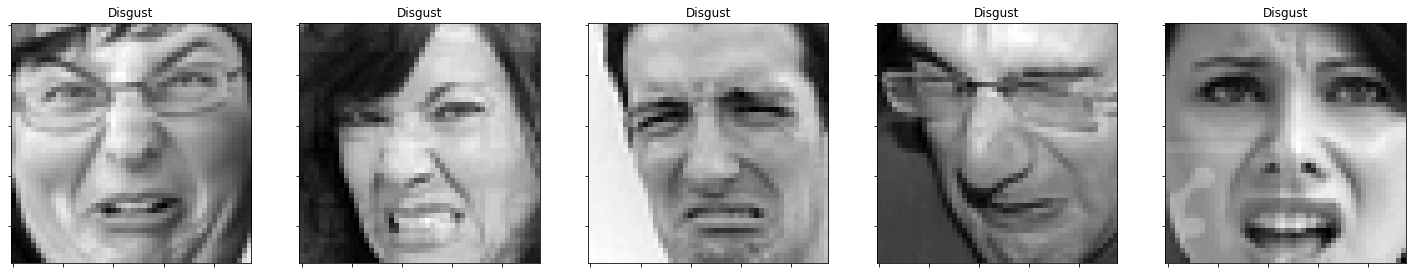

In [16]:
plot_examples(label=1)

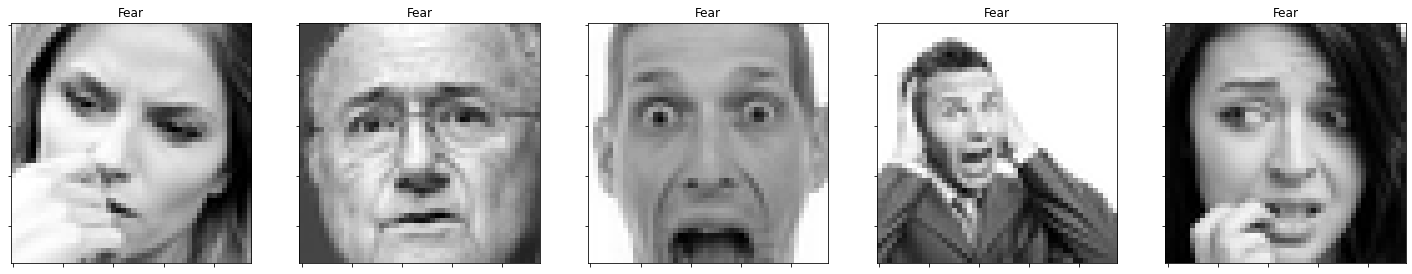

In [17]:
plot_examples(label=2)

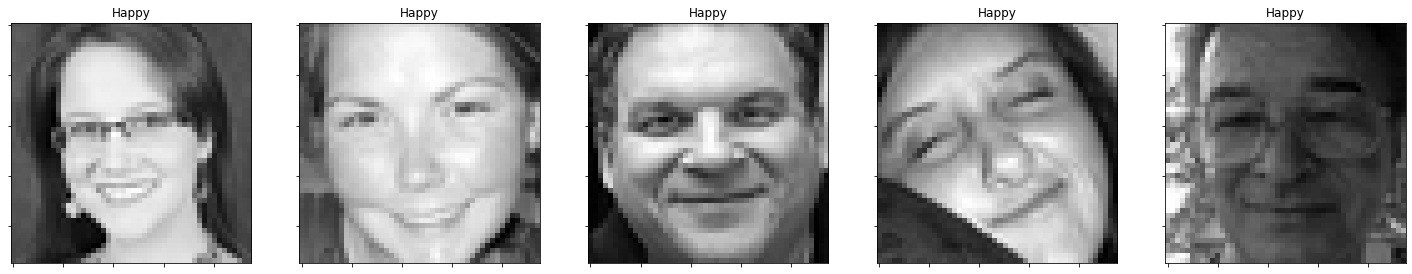

In [18]:
plot_examples(label=3)

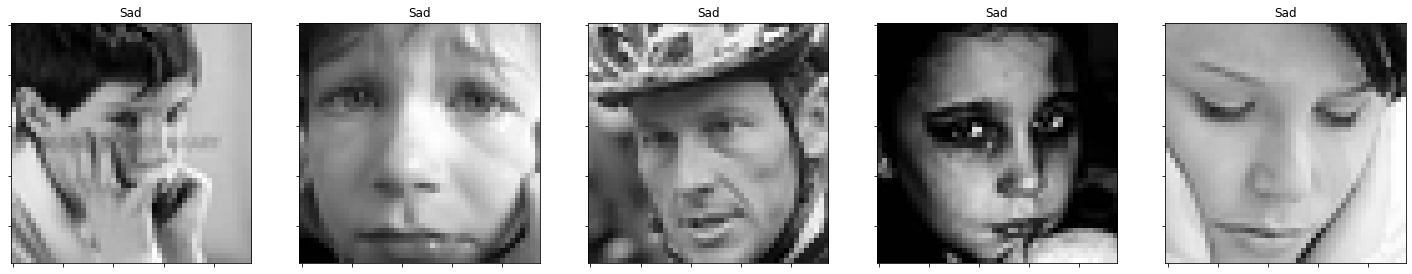

In [19]:
plot_examples(label=4)

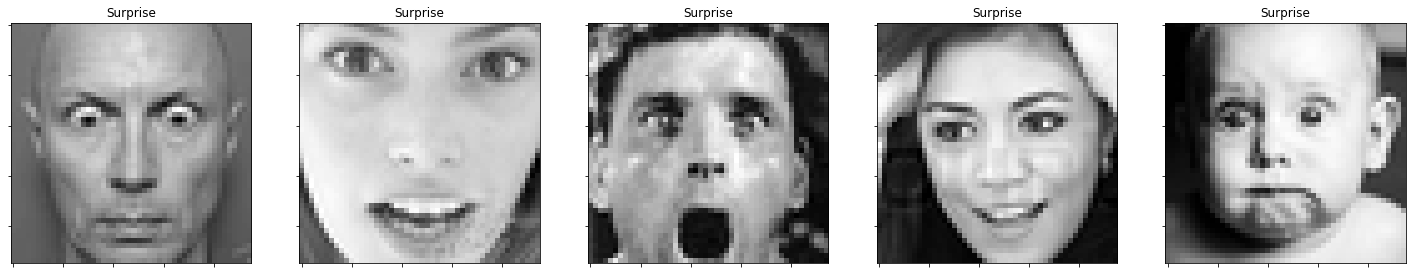

In [20]:
plot_examples(label=5)

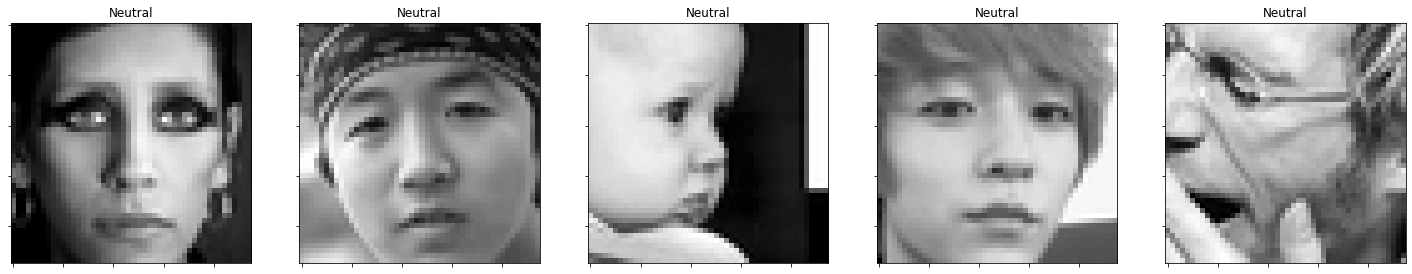

In [21]:
plot_examples(label=6)

#10. Comparison Plots

Train Labels and Validation Labels

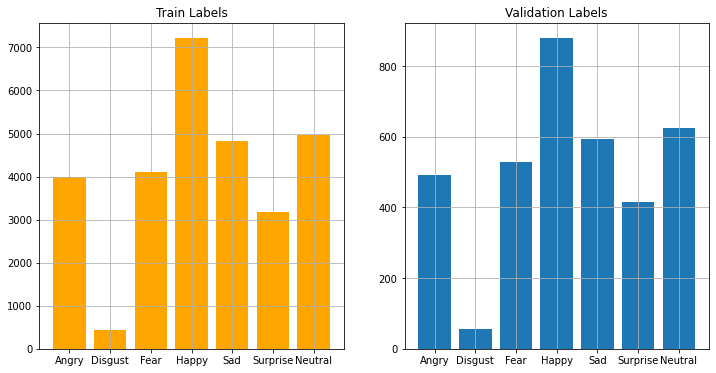

In [22]:
plot_compare_distributions(train_labels, val_labels, title1='Train Labels', title2='Validation Labels')

Train Labels and Test Labels

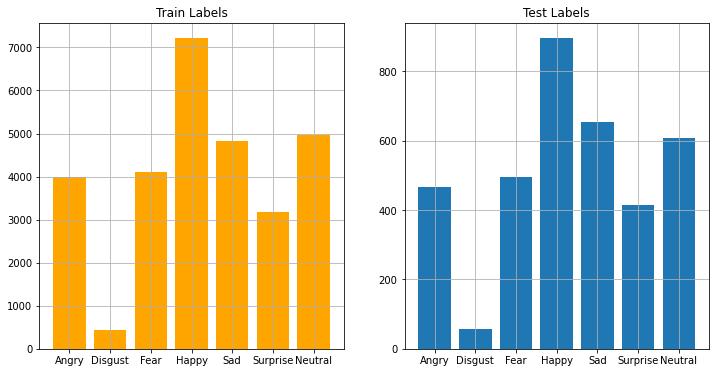

In [23]:
plot_compare_distributions(train_labels, test_labels, title1='Train Labels', title2='Test Labels')

#11. Weights

In [24]:
class_weight = dict(zip(range(0, 7), (((data[data[' Usage']=='Training']['emotion'].value_counts()).sort_index())/len(data[data[' Usage']=='Training']['emotion'])).tolist()))
class_weight

{0: 0.1391549688251071,
 1: 0.01518687519593159,
 2: 0.14270786164617366,
 3: 0.2513149186666202,
 4: 0.16823992476226968,
 5: 0.11045316799609878,
 6: 0.17294228290779895}

#12. Custom Model 1

With Convolution Layers, Pooldown Layers and Dense Layers

In [25]:
model1 = models.Sequential()

model1.add(Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(48, 48, 1)))

model1.add(MaxPool2D((2, 2)))
model1.add(Conv2D(64, (3, 3), padding='same', activation='relu'))

model1.add(MaxPool2D((2, 2)))
model1.add(Conv2D(128, (3, 3), padding='same', activation='relu'))

model1.add(MaxPool2D((2, 2)))
model1.add(Conv2D(256, (3, 3), padding='same', activation='relu'))

model1.add(MaxPool2D((2, 2)))
model1.add(Flatten())
model1.add(Dense(256, activation='relu'))
model1.add(Dense(128, activation='relu'))

model1.add(Dense(7, activation='softmax'))

#The Model

In [26]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 128)        0

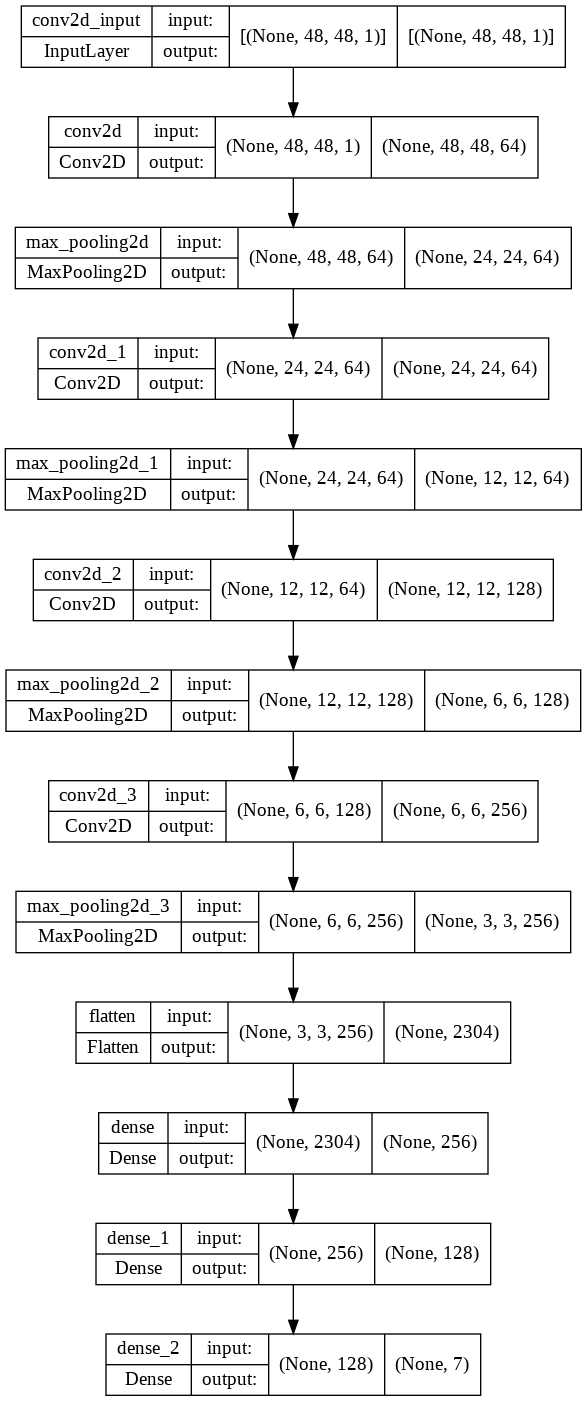

In [27]:
# Visualize the model.
plot_model(model1, to_file='model.png', show_shapes=True, show_layer_names=True)

Compiling the Model

In [28]:
model1.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

Training the Model

In [29]:
history1 = model1.fit(train_images, train_labels,
                    validation_data=(val_images, val_labels),
                    callbacks=callbackFunction('Case_1'),
                    class_weight = class_weight,
                    epochs=50,
                    batch_size=64)

Epoch 1/50
449/449 [==============================] - ETA: 0s - loss: 0.2766 - accuracy: 0.2886
Epoch 1: val_accuracy improved from -inf to 0.39315, saving model to Checkpoints/Case_1.h5
449/449 [==============================] - 18s 13ms/step - loss: 0.2766 - accuracy: 0.2886 - val_loss: 1.5966 - val_accuracy: 0.3931
Epoch 2/50
446/449 [============================>.] - ETA: 0s - loss: 0.2253 - accuracy: 0.4350
Epoch 2: val_accuracy improved from 0.39315 to 0.46336, saving model to Checkpoints/Case_1.h5
449/449 [==============================] - 5s 12ms/step - loss: 0.2253 - accuracy: 0.4350 - val_loss: 1.4075 - val_accuracy: 0.4634
Epoch 3/50
444/449 [============================>.] - ETA: 0s - loss: 0.1994 - accuracy: 0.4988
Epoch 3: val_accuracy improved from 0.46336 to 0.51379, saving model to Checkpoints/Case_1.h5
449/449 [==============================] - 6s 14ms/step - loss: 0.1993 - accuracy: 0.4990 - val_loss: 1.3024 - val_accuracy: 0.5138
Epoch 4/50
444/449 [================

Accuracy

In [30]:
train_loss, train_acc = model1.evaluate(train_images, train_labels)
print('Training Accuracy:', train_acc*100)
print('\n')

test_loss, test_acc = model1.evaluate(test_images, test_labels)
print('Testing Accuracy:', test_acc*100)
print('\n')

val_loss, val_acc = model1.evaluate(val_images, val_labels)
print('Validation Accuracy:', val_acc*100)

898/898 [==============================] - 4s 4ms/step - loss: 0.1941 - accuracy: 0.9442
Training Accuracy: 94.42335367202759


113/113 [==============================] - 1s 4ms/step - loss: 2.7022 - accuracy: 0.5497
Testing Accuracy: 54.973530769348145


113/113 [==============================] - 1s 4ms/step - loss: 2.5602 - accuracy: 0.5606
Validation Accuracy: 56.06018304824829


Predictions

In [31]:
pred_test_labels1 = model1.predict(test_images)

Plots

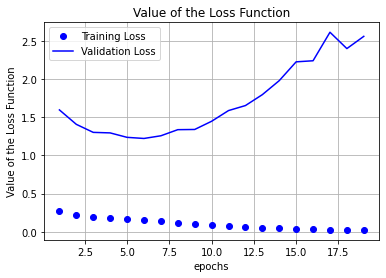

In [32]:
loss = history1.history['loss']
loss_val = history1.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, loss_val, 'b', label='Validation Loss')
plt.title('Value of the Loss Function')
plt.xlabel('epochs')
plt.ylabel('Value of the Loss Function')
plt.legend()
plt.grid()
plt.show()

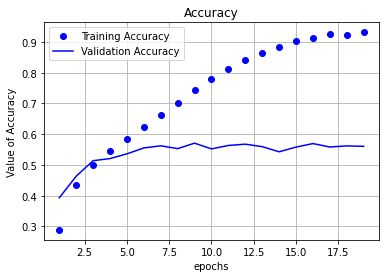

In [33]:
acc = history1.history['accuracy']
acc_val = history1.history['val_accuracy']
epochs = range(1, len(loss)+1)
plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, acc_val, 'b', label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('Value of Accuracy')
plt.legend()
plt.grid()
plt.show()

#13. Custom Model 2

With Convolution Layers, Pooldown Layers, Dropout Layers and Dense Layers

In [34]:
model2 = models.Sequential()

model2.add(Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(48, 48, 1)))
model2.add(Dropout(0.25))

model2.add(MaxPool2D((2, 2)))
model2.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model2.add(Dropout(0.25))

model2.add(MaxPool2D((2, 2)))
model2.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model2.add(Dropout(0.25))

model2.add(MaxPool2D((2, 2)))
model2.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model2.add(Dropout(0.25))

model2.add(MaxPool2D((2, 2)))
model2.add(Flatten())
model2.add(Dense(256, activation='relu'))
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.25))

model2.add(Dense(7, activation='softmax'))

The Model

In [35]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 48, 48, 64)        640       
                                                                 
 dropout (Dropout)           (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 24, 24, 64)        36928     
                                                                 
 dropout_1 (Dropout)         (None, 24, 24, 64)        0         
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                  

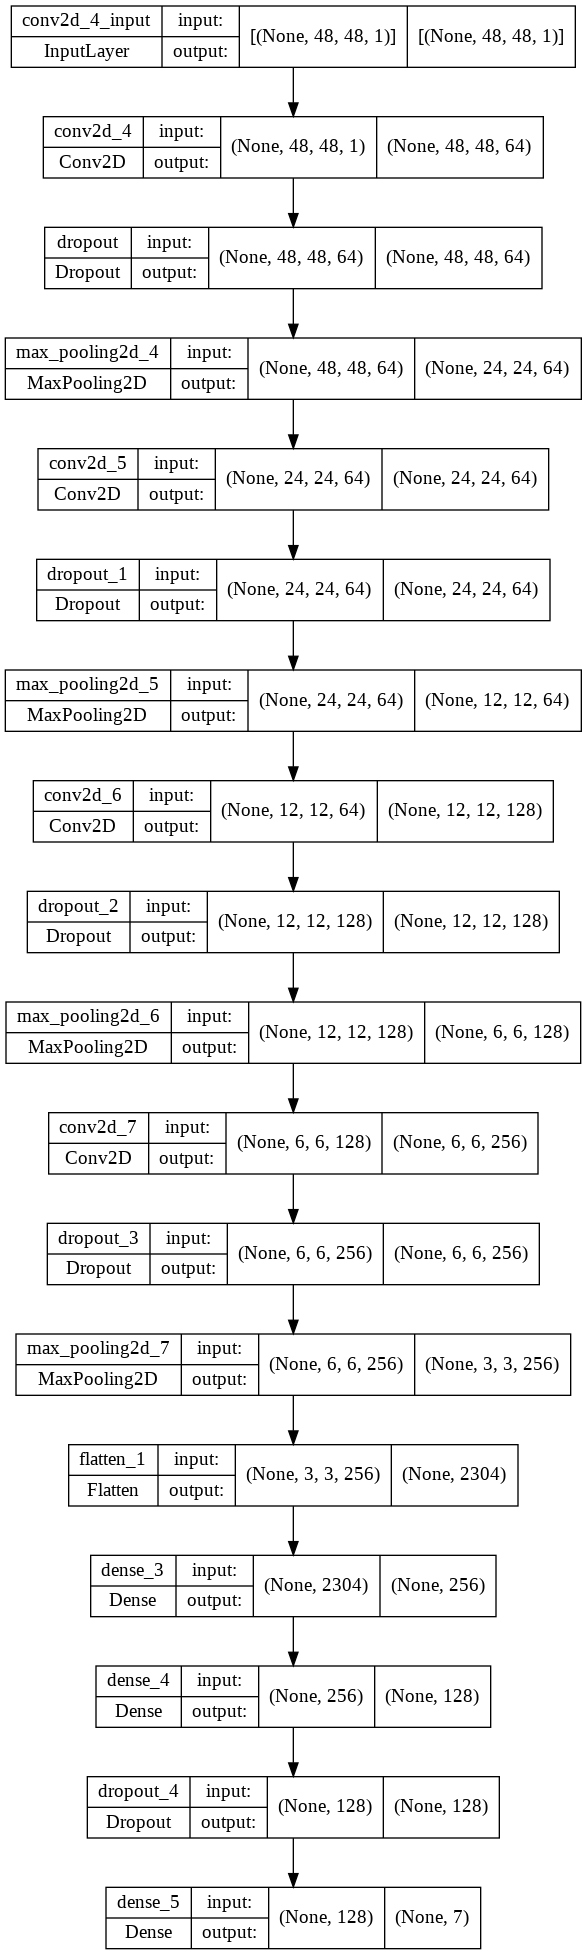

In [36]:
# Visualize the model.
plot_model(model2, to_file='model.png', show_shapes=True, show_layer_names=True)

Compiling the Model

In [37]:
model2.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

Training the Model

In [38]:
history2 = model2.fit(train_images, train_labels,
                    validation_data=(val_images, val_labels),
                    callbacks=callbackFunction('Case_2'),
                    class_weight = class_weight,
                    epochs=50,
                    batch_size=64)

Epoch 1/50
448/449 [============================>.] - ETA: 0s - loss: 0.2791 - accuracy: 0.2819
Epoch 1: val_accuracy improved from -inf to 0.33658, saving model to Checkpoints/Case_2.h5
449/449 [==============================] - 8s 15ms/step - loss: 0.2790 - accuracy: 0.2820 - val_loss: 1.6655 - val_accuracy: 0.3366
Epoch 2/50
447/449 [============================>.] - ETA: 0s - loss: 0.2391 - accuracy: 0.3992
Epoch 2: val_accuracy improved from 0.33658 to 0.39259, saving model to Checkpoints/Case_2.h5
449/449 [==============================] - 7s 15ms/step - loss: 0.2391 - accuracy: 0.3991 - val_loss: 1.5226 - val_accuracy: 0.3926
Epoch 3/50
449/449 [==============================] - ETA: 0s - loss: 0.2180 - accuracy: 0.4513
Epoch 3: val_accuracy improved from 0.39259 to 0.44246, saving model to Checkpoints/Case_2.h5
449/449 [==============================] - 7s 15ms/step - loss: 0.2180 - accuracy: 0.4513 - val_loss: 1.4722 - val_accuracy: 0.4425
Epoch 4/50
449/449 [=================

Accuracy

In [39]:
train_loss, train_acc = model2.evaluate(train_images, train_labels)
print('Training Accuracy:', train_acc*100)
print('\n')

test_loss, test_acc = model2.evaluate(test_images, test_labels)
print('Testing Accuracy:', test_acc*100)
print('\n')

val_loss, val_acc = model2.evaluate(val_images, val_labels)
print('Validation Accuracy:', val_acc*100)

898/898 [==============================] - 3s 4ms/step - loss: 0.3500 - accuracy: 0.9156
Training Accuracy: 91.5601372718811


113/113 [==============================] - 0s 4ms/step - loss: 1.3429 - accuracy: 0.5737
Testing Accuracy: 57.369738817214966


113/113 [==============================] - 0s 4ms/step - loss: 1.2634 - accuracy: 0.5865
Validation Accuracy: 58.65143537521362


Predictions

In [40]:
pred_test_labels2 = model2.predict(test_images)

Plots

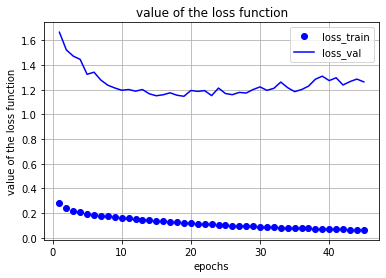

In [41]:
loss = history2.history['loss']
loss_val = history2.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'bo', label='loss_train')
plt.plot(epochs, loss_val, 'b', label='loss_val')
plt.title('value of the loss function')
plt.xlabel('epochs')
plt.ylabel('value of the loss function')
plt.legend()
plt.grid()
plt.show()

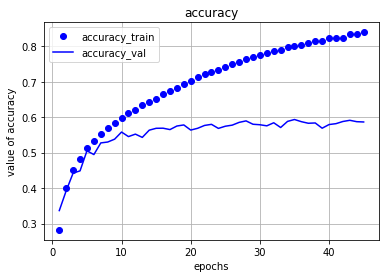

In [42]:
acc = history2.history['accuracy']
acc_val = history2.history['val_accuracy']
epochs = range(1, len(loss)+1)
plt.plot(epochs, acc, 'bo', label='accuracy_train')
plt.plot(epochs, acc_val, 'b', label='accuracy_val')
plt.title('accuracy')
plt.xlabel('epochs')
plt.ylabel('value of accuracy')
plt.legend()
plt.grid()
plt.show()

#14. Custom Model 3

With Convolution Layers, Pooldown Layer, Droupout Layers, Batch Normalization and Dense Layers

In [43]:
model3 = models.Sequential()

model3.add(Conv2D(64, (1, 1), padding='same', activation='relu', input_shape=(48, 48, 1)))
model3.add(BatchNormalization())
model3.add(Dropout(0.25))

model3.add(Conv2D(128, (3, 3),padding='same', activation='relu'))
model3.add(BatchNormalization())
model3.add(Dropout(0.25))

model3.add(Conv2D(256, (5, 5),padding='same', activation='relu'))
model3.add(BatchNormalization())
model3.add(MaxPool2D((2, 2),padding="same"))
model3.add(Dropout(0.25))

model3.add(Flatten())

model3.add(Dense(128))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(Dropout(0.25))

model3.add(Dense(256))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(Dropout(0.25))

model3.add(Dense(7, activation='softmax'))

The Model

In [44]:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 48, 48, 64)        128       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 dropout_5 (Dropout)         (None, 48, 48, 64)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 48, 48, 128)       73856     
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 128)      512       
 hNormalization)                                                 
                                                                 
 dropout_6 (Dropout)         (None, 48, 48, 128)      

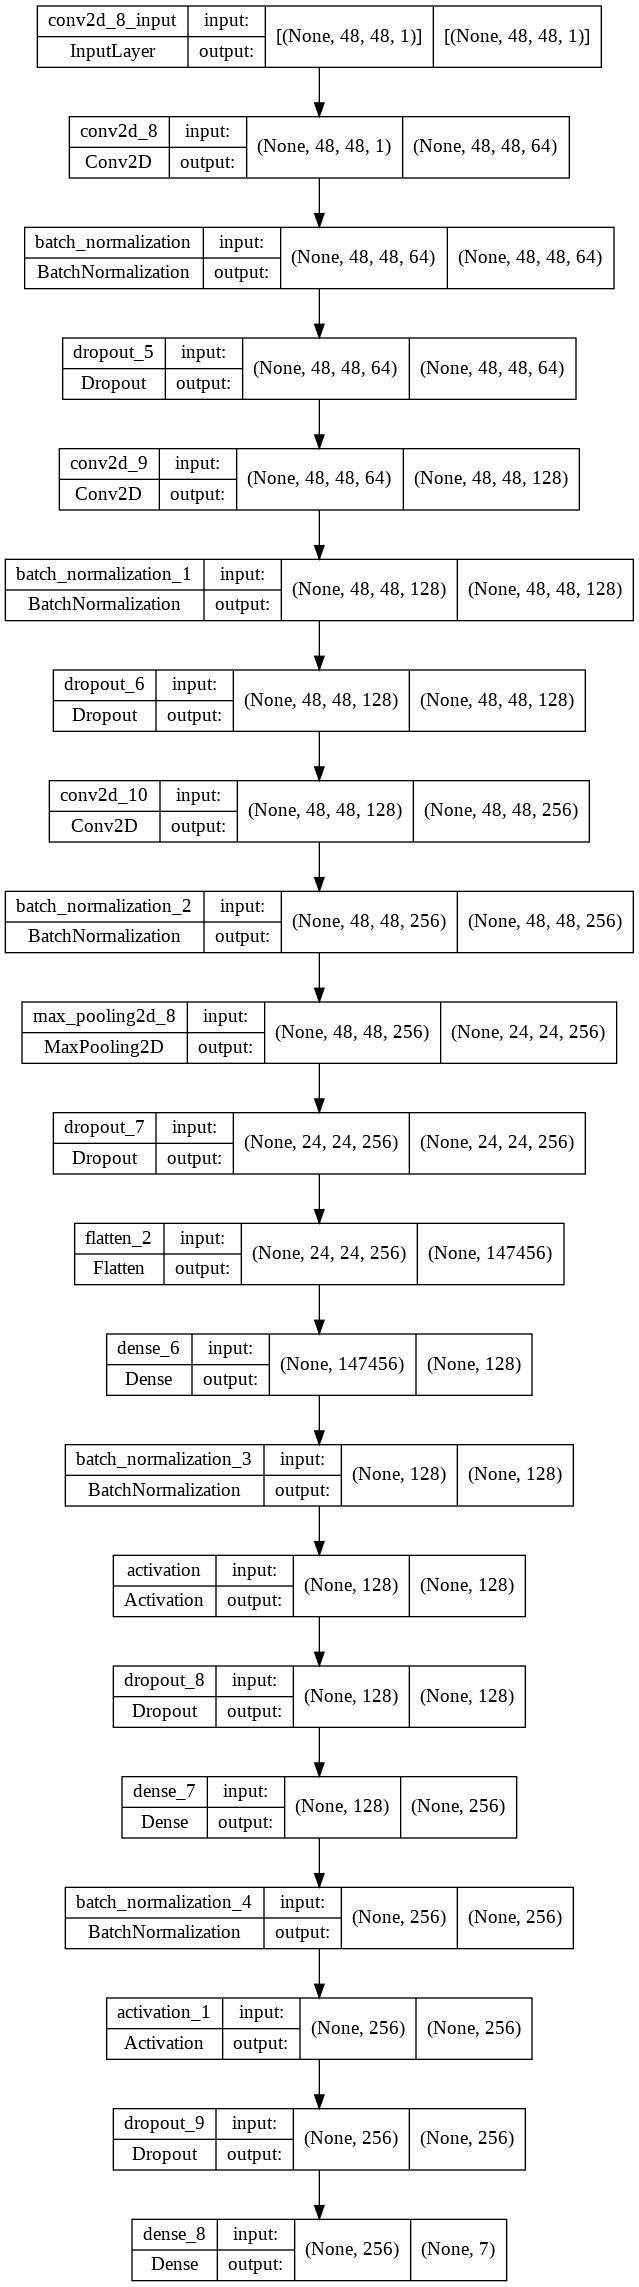

In [45]:
# Visualize the model.
plot_model(model3, to_file='model.png', show_shapes=True, show_layer_names=True)

Compiling the Model

In [46]:
model3.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

Training the Model

In [47]:
history3 = model3.fit(train_images, train_labels,
                    validation_data=(val_images, val_labels),
                    callbacks=callbackFunction('Case_3'),
                    class_weight = class_weight,
                    epochs=50,
                    batch_size=64)

Epoch 1/50
449/449 [==============================] - ETA: 0s - loss: 0.2747 - accuracy: 0.3289
Epoch 1: val_accuracy improved from -inf to 0.37977, saving model to Checkpoints/Case_3.h5
449/449 [==============================] - 50s 104ms/step - loss: 0.2747 - accuracy: 0.3289 - val_loss: 1.6068 - val_accuracy: 0.3798
Epoch 2/50
449/449 [==============================] - ETA: 0s - loss: 0.2242 - accuracy: 0.4404
Epoch 2: val_accuracy improved from 0.37977 to 0.47813, saving model to Checkpoints/Case_3.h5
449/449 [==============================] - 43s 97ms/step - loss: 0.2242 - accuracy: 0.4404 - val_loss: 1.3671 - val_accuracy: 0.4781
Epoch 3/50
449/449 [==============================] - ETA: 0s - loss: 0.1959 - accuracy: 0.5143
Epoch 3: val_accuracy improved from 0.47813 to 0.50961, saving model to Checkpoints/Case_3.h5
449/449 [==============================] - 43s 97ms/step - loss: 0.1959 - accuracy: 0.5143 - val_loss: 1.3260 - val_accuracy: 0.5096
Epoch 4/50
449/449 [=============

Accuracy

In [48]:
train_loss, train_acc = model3.evaluate(train_images, train_labels)
print('Train Accuracy:', train_acc*100)
print('\n')

test_loss, test_acc = model3.evaluate(test_images, test_labels)
print('Test Accuracy:', test_acc*100)
print('\n')

val_loss, val_acc = model3.evaluate(val_images, val_labels)
print('Validation Accuracy:', val_acc*100)

898/898 [==============================] - 13s 13ms/step - loss: 0.0352 - accuracy: 0.9876
Train Accuracy: 98.7634539604187


113/113 [==============================] - 2s 14ms/step - loss: 2.4680 - accuracy: 0.5600
Test Accuracy: 56.00445866584778


113/113 [==============================] - 2s 13ms/step - loss: 2.4234 - accuracy: 0.5656
Validation Accuracy: 56.56171441078186


Predictions

In [49]:
pred_test_labels3 = model3.predict(test_images)

Plots

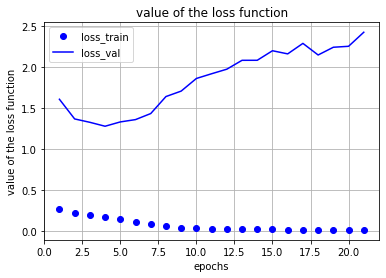

In [50]:
loss = history3.history['loss']
loss_val = history3.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'bo', label='loss_train')
plt.plot(epochs, loss_val, 'b', label='loss_val')
plt.title('value of the loss function')
plt.xlabel('epochs')
plt.ylabel('value of the loss function')
plt.legend()
plt.grid()
plt.show()

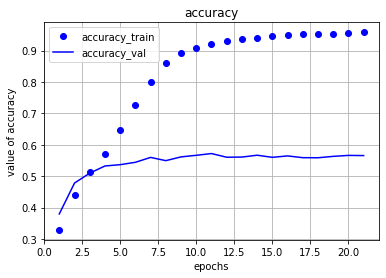

In [51]:
acc = history3.history['accuracy']
acc_val = history3.history['val_accuracy']
epochs = range(1, len(loss)+1)
plt.plot(epochs, acc, 'bo', label='accuracy_train')
plt.plot(epochs, acc_val, 'b', label='accuracy_val')
plt.title('accuracy')
plt.xlabel('epochs')
plt.ylabel('value of accuracy')
plt.legend()
plt.grid()
plt.show()

#15. Analyzing the Results

For Model 1

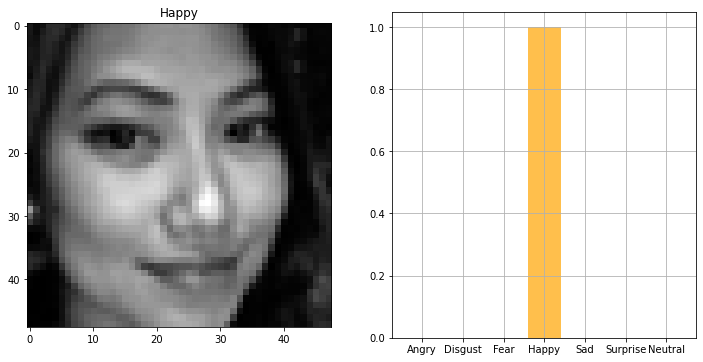

In [52]:
plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels1, 19)

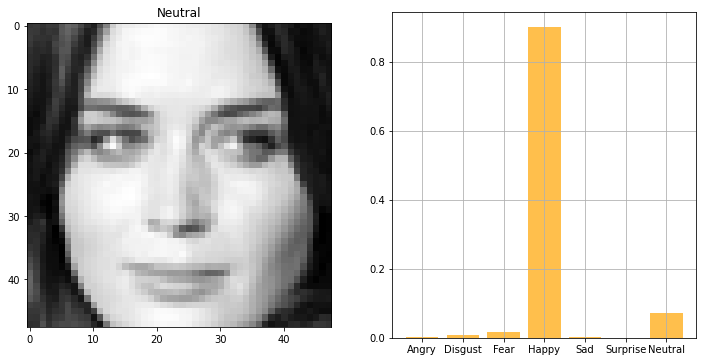

In [53]:
plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels1, 119)

Form Model 2

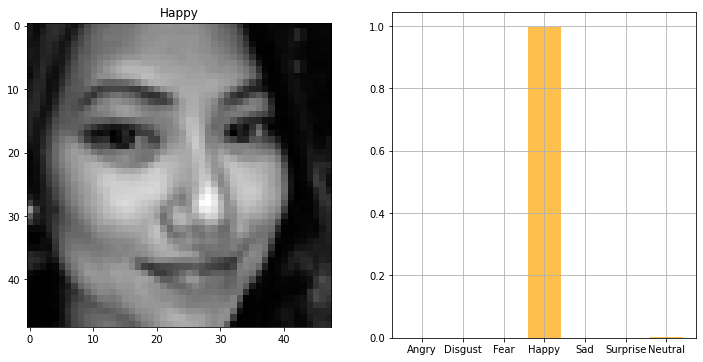

In [54]:
plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels2, 19)

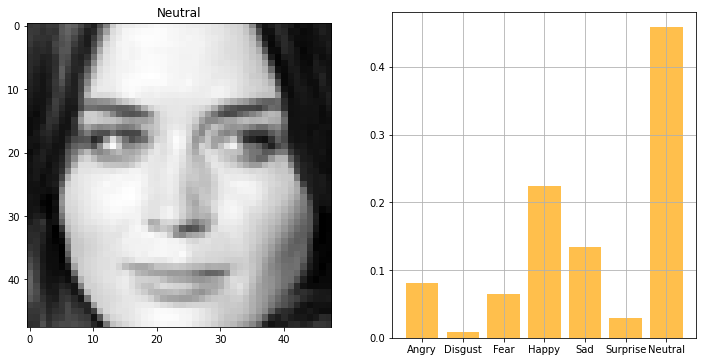

In [55]:
plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels2, 119)

For Model 3

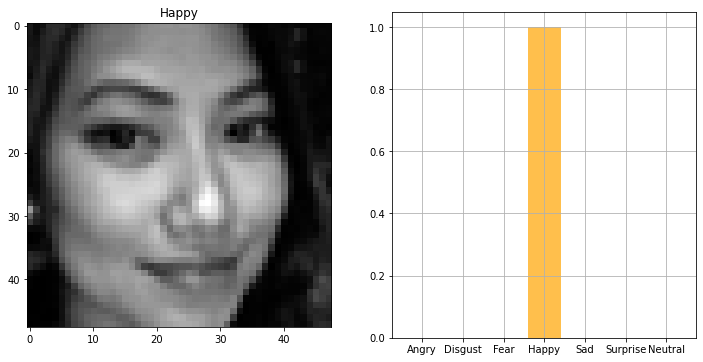

In [56]:
plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels3, 19)

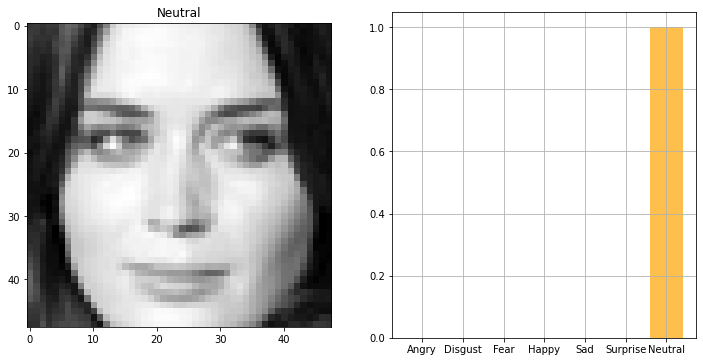

In [57]:
plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels3, 119)

16. Predicted Label Comparision Plot

Model 1

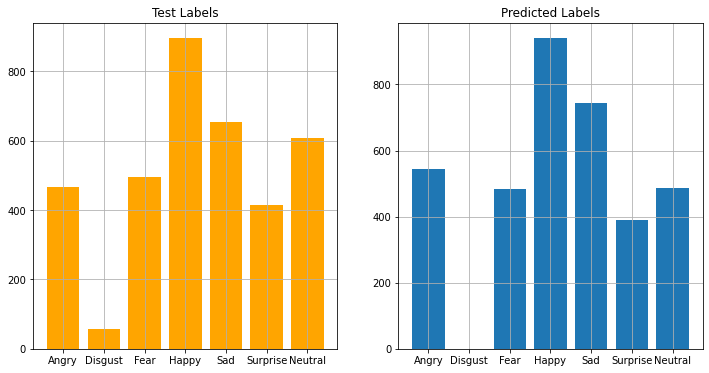

In [58]:
plot_compare_distributions(test_labels, pred_test_labels1, title1='Test Labels', title2='Predicted Labels')

Model 2

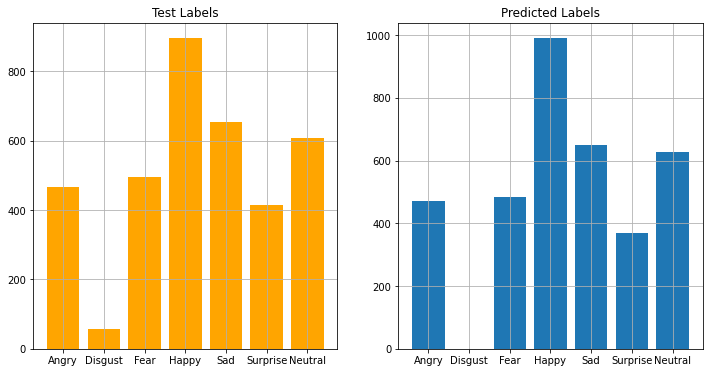

In [59]:
plot_compare_distributions(test_labels, pred_test_labels2, title1='Test Labels', title2='Predicted Labels')

Model 3

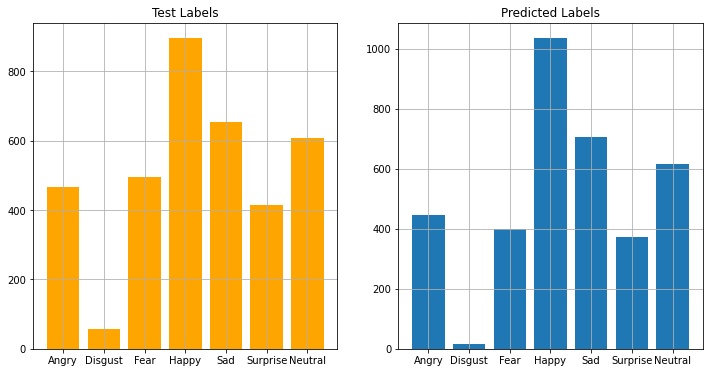

In [60]:
plot_compare_distributions(test_labels, pred_test_labels3, title1='Test Labels', title2='Predicted Labels')

#17. Analysis of Incorrect Prediction

We are using Confusion Matrix in this case.

Model 1

In [61]:
df_compare = pd.DataFrame()
df_compare['real'] = test_labels.argmax(axis=1)
df_compare['pred'] = pred_test_labels1.argmax(axis=1)
df_compare['wrong'] = np.where(df_compare['real']!=df_compare['pred'], 1, 0)

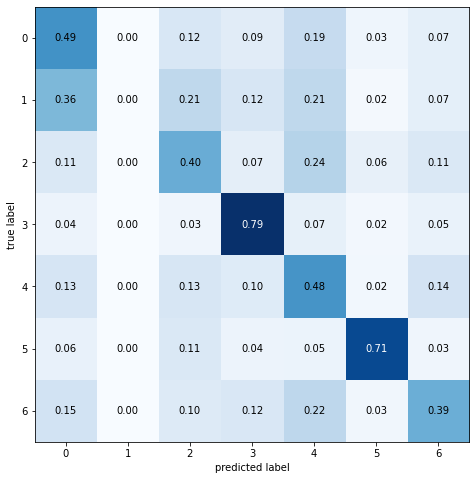

In [62]:
conf_mat = confusion_matrix(test_labels.argmax(axis=1), pred_test_labels1.argmax(axis=1))

fig, ax = plot_confusion_matrix(conf_mat=conf_mat,
                                show_normed=True,
                                show_absolute=False,
                                figsize=(8, 8))
fig.show()

Model 2

In [63]:
df_compare = pd.DataFrame()
df_compare['real'] = test_labels.argmax(axis=1)
df_compare['pred'] = pred_test_labels2.argmax(axis=1)
df_compare['wrong'] = np.where(df_compare['real']!=df_compare['pred'], 1, 0)

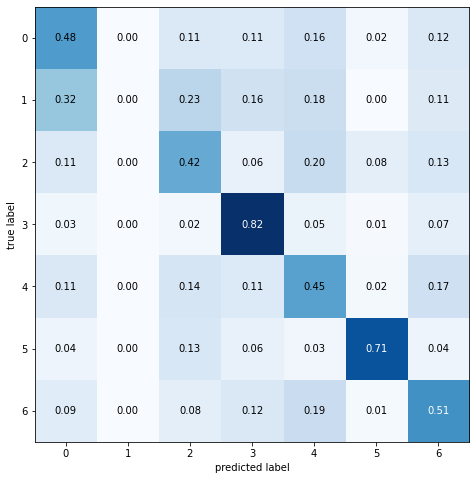

In [64]:
conf_mat = confusion_matrix(test_labels.argmax(axis=1), pred_test_labels2.argmax(axis=1))

fig, ax = plot_confusion_matrix(conf_mat=conf_mat,
                                show_normed=True,
                                show_absolute=False,
                                figsize=(8, 8))
fig.show()

Model 3

In [65]:
df_compare = pd.DataFrame()
df_compare['real'] = test_labels.argmax(axis=1)
df_compare['pred'] = pred_test_labels2.argmax(axis=1)
df_compare['wrong'] = np.where(df_compare['real']!=df_compare['pred'], 1, 0)

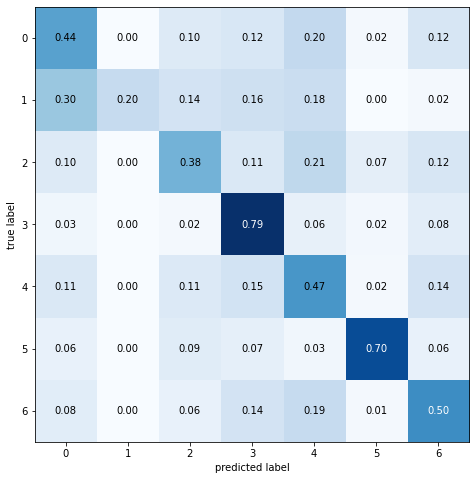

In [66]:
conf_mat = confusion_matrix(test_labels.argmax(axis=1), pred_test_labels3.argmax(axis=1))

fig, ax = plot_confusion_matrix(conf_mat=conf_mat,
                                show_normed=True,
                                show_absolute=False,
                                figsize=(8, 8))
fig.show()

In [79]:
model_json=model1.to_json()+model2.to_json()+model3.to_json()
with open("model_json","w") as json_file:
    json_file.write(model_json)

In [110]:
import cv2
from model import FacialExpressionModel
import numpy as np
facec = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
model = FacialExpressionModel("model.json", "model_weights.h5")
font = cv2.FONT_HERSHEY_SIMPLEX
class VideoCamera(object):
    def __init__(self):
        self.video = cv2.VideoCapture("path to video file")
def __del__(self):
        self.video.release()
# returns camera frames along with bounding boxes and predictions
def get_frame(self):
        _, fr = self.video.read()
        gray_fr = cv2.cvtColor(fr, cv2.COLOR_BGR2GRAY)
        faces = facec.detectMultiScale(gray_fr, 1.3, 5)
for (x, y, w, h) in faces:
            fc = gray_fr[y:y+h, x:x+w]

roi = cv2.resize(fc, (48, 48))
            pred = model.predict_emotion(roi[np.newaxis, :, :, 
            np.newaxis])
            
cv2.putText(fr, pred, (x, y), font, 1, (255, 255, 0), 2)
            cv2.rectangle(fr,(x,y),(x+w,y+h),(255,0,0),2)
_, jpeg = cv2.imencode('.jpg', fr)
        return jpeg.tobytes()            

IndentationError: ignored